In [1]:
import os
import pickle
import pathlib
from pathlib import Path
import numpy as np
from loguru import logger
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import backend as K
import json
import pandas as pd

In [2]:
def load_json(filename):# Loading raw json file
    with open(filename, 'r', encoding='utf8') as file:   
        return json.load(file)
    
def save_json(data, filename):
    json_str = json.dumps(data)
    with open(filename, "w") as f: 
        f.write(json_str) 

In [3]:
root = Path('/home/jarod/git/innovation/allocine-sentiment-analysis')
corpus = root / 'data/allocine_filtered'
data = root / 'data/json'

train_ds = corpus / 'train'
eval_ds = corpus / 'eval'

dev_path = data / 'dev.json'
train_path = data / 'train.json'
test_path = data / 'test.json'

users_path = data / 'users.json'
users_add_1_path = data / 'users_additional_1.json'
users_add_2_path = data / 'users_additional_2.json'
users_add_3_path = data / 'users_additional_3.json'

movies_path = data / 'movies.json'
movies_add_path = data / 'movies_additional.json'


In [45]:
# explore meta-data about films

In [37]:
movies = load_json(movies_path)
movies_add = load_json(movies_add_path)

In [36]:
# concat and save meta-data about users

In [28]:
users_add_1 = load_json(users_add_1_path)
users_add_2 = load_json(users_add_2_path)
users_add_3 = load_json(users_add_3_path)

In [30]:
users_add = dict(users_add_1) # usr2add
users_add.update(users_add_2)
users_add.update(users_add_3)

In [34]:
save_json(users_add, data / 'users_additional.json')

In [42]:
users_add = load_json(data / 'users_additional.json')

In [37]:
# construct final dataset

In [38]:
users = load_json(users_path)

In [47]:
dev = load_json(dev_path)
train = load_json(train_path)
test = load_json(test_path)

print(len(dev))
print(len(train))
print(len(test))

100400
665962
85847


In [31]:
users2reviews = {}
reviews2users = {}

In [32]:
full = train + dev + test

In [33]:
for sample in full:
    # users to reviews mapping
    if sample['user_id'] not in users2reviews:
        users2reviews[sample['user_id']] = []
    users2reviews[sample['user_id']].append(sample)
    
    # reviews to users mapping
    reviews2users[sample['review_id']] = sample['user_id']

In [34]:
save_json(users2reviews, data / 'users2reviews.json')
save_json(reviews2users, data / 'reviews2users.json')

In [76]:
# compute user stats

In [48]:
users2scores = {}
for (user, rws) in users2reviews.items():
    scores = []
    for rw in rws:
        if 'note' in rw:
            scores.append(rw['note'])
    
    users2scores[user] = scores

In [95]:
save_json(users2scores, data / 'users2scores.json')

In [96]:
# construct dataset

In [52]:
for i in range(len(test)):
    sample = test[i]

    # add movie meta-data
    sample['movie_id'] = sample['movie']['id']
    sample.pop('movie', None)
    movie_add = movies_add[sample['movie_id']]
    movie_add.pop('data', None)
    sample.update(movie_add)
    
    # add user meta-data
    user_add = users_add[sample['user_id']]
    sample.update(user_add)
    
    # add user stats
    scores = np.array(users2scores[sample['user_id']])
    if len(scores) > 0:
        sample['note_mean'] = scores.mean()
        sample['note_std'] = scores.std()
    else:
        sample['note_mean'] = 0.0
        sample['note_std'] = 1.0
    

In [50]:
print(train[0])

{'review_id': 'review_58145147', 'name': 'AM11', 'user_id': 'Z20051105131449940367618', 'commentaire': '"Ce n\'est pas ce qui se trouve en face de vous, c\'est qui se tient à côté de vous". Cette phrase qui est la tagline du film veut tout dire et le résume parfaitement. Pour son premier film qui n\'est pas un de science-fiction, Joseph Kosinski s\'intéresse à ces pompiers d\'élite en tant que professionnels, mais surtout en tant qu\'hommes. Il dresse un très beau portrait d\'une bande de potes prêts à tout sacrifier pour protéger leur environnement des flammes. Le film est davantage centré sur le quotidien de ces héros qui font face à de nombreux dilemmes, mais cela n\'empêche pas que les scènes de terrain soient aussi superbes que terribles et surtout vraiment impressionnantes comme en témoigne notamment cet excellent final. C\'est une histoire inspirée de faits réels donc si vous ne la connaissez pas, le mieux est dans un premier temps de la découvrir à travers le film, l\'expérienc

In [53]:
save_json(dev, data / 'dev_full.json')
save_json(train, data / 'train_full.json')
save_json(test, data / 'test_full.json')

In [113]:
df_dev = pd.DataFrame(dev)

In [123]:
df_dev.head(1)

,review_id,name,user_id,commentaire,movie,note,directors,kinds,title,rating,review,subscriber,note_mean,note_std
0,review_57113853,I'm A Rocket Man,Z20150411212834470532236,Ce téléfilm est tout simplement bouleversant !...,{'id': '244430'},5.0,[Bourlem Guerdjou],[Drame],"Marion, 13 ans pour toujours",2081,1350,81,3.28304,1.454811


In [4]:
# generate dataset

In [10]:
import utils
import spacy

In [16]:
# Loading SpaCy model from tokenization utilities
spacy.prefer_gpu()
nlp = spacy.load("fr_core_news_sm")

with open(pathlib.Path(data / 'stopwords.json'), "r", encoding="utf8") as file:
    nlp.Defaults.stop_words = set(json.load(file))

In [54]:
ds_train_path = data / 'train_full.json'
ds_dev_path = data / 'dev_full.json'
ds_test_path = data / 'test_full.json'

In [78]:
#ds_dev = load_json(ds_dev_path)
#ds_train = load_json(ds_train_path)
ds_test = load_json(ds_test_path)

In [79]:
clean = []
for i in range(len(ds_test)):
    review = ds_test[i]
    # Filters and standardize review's content
    filtered = utils.filter_comment(review["commentaire"], nlp=None)
    if len(filtered) == 0:
        print('remove')
    else:
        review["commentaire"] = filtered
        clean.append(review)

remove
remove


In [80]:
len(clean)

85845

In [ ]:
# csv

In [81]:
#df_dev = pd.DataFrame(clean)
#df_train = pd.DataFrame(clean)
df_test = pd.DataFrame(clean)
df_train.head(5)

,review_id,name,user_id,commentaire,note,movie_id,directors,kinds,title,rating,review,subscriber,note_mean,note_std
0,review_58145147,AM11,Z20051105131449940367618,ce n est pas ce qui se trouve en face de vous ...,4.0,229864,[Joseph Kosinski],"[Drame, Biopic]",Line of Fire,6004,2929,2816,2.854198,0.769817
1,review_59303833,this is my movies,Z20051220181957240298347,... en soi je n ai rien contre ce genre de réc...,3.5,229864,[Joseph Kosinski],"[Drame, Biopic]",Line of Fire,3662,2564,344,3.523349,0.799468
2,review_61916672,Shephard69,Z20121226180301760912584,pour sa troisième réalisation après tron l hér...,4.5,229864,[Joseph Kosinski],"[Drame, Biopic]",Line of Fire,2387,1882,127,3.400558,1.147512
3,review_1000190786,Tayop,Z20121022182542230468657,joseph kosinski offre de nouvelles images ébou...,3.0,229864,[Joseph Kosinski],"[Drame, Biopic]",Line of Fire,5797,1342,44,2.914270,0.894678
4,review_59207755,ned123,Z20061211223247607682175,j ai vu un film... qui traite d un drame humai...,3.5,229864,[Joseph Kosinski],"[Drame, Biopic]",Line of Fire,1338,1138,67,3.638662,0.815544


In [82]:
df_test_clean = df_test.drop(columns=['name', 'user_id', 'title'])
df_test_clean.head(10)

,review_id,commentaire,movie_id,directors,kinds,rating,review,subscriber,note_mean,note_std
0,review_59354742,12 jours un film que j ai raté à sa sortie et ...,253727,[Raymond Depardon],[Documentaire],4518,2741,1593,2.384467,1.256869
1,review_62570109,ces lueurs dans ces yeux... soit ils sont tous...,253727,[Raymond Depardon],[Documentaire],4300,2559,307,2.986261,1.159985
2,review_58180650,il s agit d un documentaire sans la moindre ac...,253727,[Raymond Depardon],[Documentaire],2699,1286,299,2.788321,1.401541
3,review_57696986,un documentaire magnifique dans cette unité ly...,253727,[Raymond Depardon],[Documentaire],2232,2138,245,3.688907,0.892136
4,review_57736972,un documentaire très intéressant quand bien mê...,253727,[Raymond Depardon],[Documentaire],2544,2139,465,2.957447,1.079520
5,review_57510418,c est un documentaire vraiment remarquable. il...,253727,[Raymond Depardon],[Documentaire],2054,2025,586,3.758964,1.021516
6,review_57494638,depuis 2013 le maintien sans son consentement ...,253727,[Raymond Depardon],[Documentaire],2147,2054,516,2.568898,0.981461
7,review_1000981932,comme toujours raymond depardon propose un doc...,253727,[Raymond Depardon],[Documentaire],1608,1227,48,2.673996,1.024244
8,review_57550213,depardon commettait il y a plusieurs années ur...,253727,[Raymond Depardon],[Documentaire],1100,1078,184,3.349508,0.966672
9,review_57505347,j ai connu raymond depardon plus inspiré plus ...,253727,[Raymond Depardon],[Documentaire],1159,1018,148,3.377712,0.769126


In [88]:
df_dev_clean.to_csv(root / 'data/csv/dev_std.csv', index=False)
df_train_clean.to_csv(root / 'data/csv/train_std.csv', index=False)
df_test_clean.to_csv(root / 'data/csv/test_std.csv', index=False)

In [38]:
# keras dataset
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [5]:
# raw_ds_eval = tf.keras.preprocessing.text_dataset_from_directory(
#     eval,
#     label_mode='categorical',
#     batch_size=1
# )

In [6]:
df_dev = pd.read_csv(root / 'data/csv/dev_std.csv')

In [198]:
df_dev.head(5)

,review_id,commentaire,note,movie_id,directors,kinds,rating,review,subscriber,note_mean,note_std
0,review_57113853,ce téléfilm est tout simplement bouleversant !...,5.0,244430,['Bourlem Guerdjou'],['Drame'],2081,1350,81,3.283040,1.454811
1,review_53044607,une fiction convaincainte qui a le mérite de m...,3.5,244430,['Bourlem Guerdjou'],['Drame'],1971,1482,56,3.063309,0.843267
2,review_60265420,énorme ce film parmi les meilleurs biopics doc...,4.0,244430,['Bourlem Guerdjou'],['Drame'],2784,1473,88,3.204444,0.855299
3,review_55880325,mario 13 ans pour toujours 2016 tv5 monde le 0...,2.0,244430,['Bourlem Guerdjou'],['Drame'],2070,938,66,2.385204,1.228212
4,review_53015074,un film choque coups de poing à la fois très r...,5.0,244430,['Bourlem Guerdjou'],['Drame'],1516,1098,30,2.834375,1.053598


In [199]:
dev_feats = df_dev.copy().drop(columns=['review_id'])
dev_reviews = dev_feats.pop('commentaire')
dev_labels = dev_feats.pop('note')

In [200]:
dev_feats = dev_feats.astype({"movie_id": str, "rating": np.float32, "review": np.float32, "subscriber": np.float32})

In [201]:
#dev_feats.head()

In [202]:
dev_labels.head()

0    5.0
1    3.5
2    4.0
3    2.0
4    5.0
Name: note, dtype: float64

In [203]:
inputs = {}

for name, column in dev_feats.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'movie_id': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'movie_id')>,
 'directors': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'directors')>,
 'kinds': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'kinds')>,
 'rating': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'rating')>,
 'review': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'review')>,
 'subscriber': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'subscriber')>,
 'note_mean': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'note_mean')>,
 'note_std': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'note_std')>}

In [98]:
# voir en bas
max_features = 20000
embedding_dim = 128
sequence_length = 10000

vectorize_layer = TextVectorization(
    standardize=None,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

vectorize_layer.adapt(np.array(df_dev['commentaire']))

# text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
# x = vectorize_layer(text_input)

In [204]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = preprocessing.Normalization()
norm.adapt(np.array(df_dev[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'normalization_5')>

In [205]:
preprocessed_inputs = [all_numeric_inputs]

In [206]:
for feature in ['movie_id', 'directors', 'kinds']:
    lookup = preprocessing.StringLookup(vocabulary=np.unique(dev_feats[feature]))
    one_hot = preprocessing.CategoryEncoding(max_tokens=lookup.vocab_size())

    x = lookup(inputs[feature])
    x = one_hot(x)
    preprocessed_inputs.append(x)

In [207]:
preprocessed_inputs

[<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'normalization_5')>,
 <KerasTensor: shape=(None, 450) dtype=float32 (created by layer 'category_encoding_24')>,
 <KerasTensor: shape=(None, 421) dtype=float32 (created by layer 'category_encoding_25')>,
 <KerasTensor: shape=(None, 153) dtype=float32 (created by layer 'category_encoding_26')>]

In [208]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)
input_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)
#input_preprocessing = tf.keras.Model(inputs, preprocessed_inputs)

In [209]:
dev_feats_dict = {name: np.array(value) 
                         for name, value in dev_feats.items()}

In [210]:
dev_feats_dict

{'movie_id': array(['244430', '244430', '244430', ..., '221892', '221892', '221892'],
       dtype=object),
 'directors': array(["['Bourlem Guerdjou']", "['Bourlem Guerdjou']",
        "['Bourlem Guerdjou']", ..., "['Xavier Beauvois']",
        "['Xavier Beauvois']", "['Xavier Beauvois']"], dtype=object),
 'kinds': array(["['Drame']", "['Drame']", "['Drame']", ...,
        "['Comédie dramatique']", "['Comédie dramatique']",
        "['Comédie dramatique']"], dtype=object),
 'rating': array([2.081e+03, 1.971e+03, 2.784e+03, ..., 2.000e+00, 1.000e+01,
        1.000e+00], dtype=float32),
 'review': array([1.350e+03, 1.482e+03, 1.473e+03, ..., 2.000e+00, 2.000e+00,
        1.000e+00], dtype=float32),
 'subscriber': array([81., 56., 88., ...,  0.,  0.,  0.], dtype=float32),
 'note_mean': array([3.28303965, 3.06330935, 3.20444444, ..., 4.25      , 0.5       ,
        0.5       ]),
 'note_std': array([1.4548108 , 0.84326736, 0.85529866, ..., 0.25      , 0.        ,
        0.        ])}

In [93]:
general_model(model1, inputs)

In [37]:
dev_feats_dict = {name:values[:1] for name, values in dev_feats_dict.items()}
input_preprocessing(dev_feats_dict)

<tf.Tensor: shape=(1, 1029), dtype=float32, numpy=
array([[1.02904   , 1.2081345 , 0.01518381, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)>

In [44]:
max_features = 20000
embedding_dim = 128
sequence_length = 10000

vectorize_layer = TextVectorization(
    standardize=None,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

vectorize_layer.adapt(dev_reviews.tolist())


In [46]:
vectorize_layer

In [ ]:
nputs = keras.Input(shape=input_shape)
x = preprocessing_layer(inputs)

In [94]:
# Keras fresh start

In [236]:
def create_mlp(preprocessing, inputs):
	# return our model
    body = tf.keras.Sequential([
        layers.Dense(256, activation="relu"),
        layers.Dense(128)
    ])

    preprocessed_inputs = preprocessing(inputs)
    result = body(preprocessed_inputs)
    
    return tf.keras.Model(inputs, result)

# def create_mlp(preprocessing, inputs):
# 	# return our model
# 	return tf.keras.Sequential([
#         layers.Dense(64, input_dim=dim, activation="relu"),
#         layers.Dense(32)
#       ])

In [237]:
def create_cnn(max_features, embedding_dim):
    # A integer input for vocab indices.
    inputs = tf.keras.Input(shape=(None,), dtype="int64")
    

    # Next, we add a layer to map those vocab indices into a space of dimensionality
    # 'embedding_dim'.
    x = layers.Embedding(max_features, embedding_dim)(inputs)
    x = layers.Dropout(0.5)(x)

    # Conv1D + global max pooling
    x = layers.Conv1D(64, 2, padding="valid", activation="relu", strides=1)(x)
    x = layers.Conv1D(64, 4, padding="valid", activation="relu", strides=1)(x)
    x = layers.GlobalMaxPooling1D()(x)

    # We add a vanilla hidden layer:
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    
    model = tf.keras.Model(inputs, x)
    
    
    # A string input
    inputs = tf.keras.Input(shape=(1,), dtype="string")
    # Turn strings into vocab indices
    indices = vectorize_layer(inputs)
    # Turn vocab indices into predictions
    outputs = model(indices)
    
    return tf.keras.Model(inputs, outputs)

In [238]:
# create the MLP and CNN models
mlp = create_mlp(tf.keras.Model(inputs, preprocessed_inputs_cat), inputs)
cnn = create_cnn(max_features, embedding_dim)

# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = layers.concatenate([mlp.output, cnn.output])

# our final FC layer head will have two dense layers, the final one
# being our regression head
x = layers.Dense(64, activation="relu")(combinedInput)
x = layers.Dense(10, activation="linear")(x)
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = tf.keras.Model(inputs=[mlp.input, cnn.input], outputs=x) #[mlp.input, cnn.input]

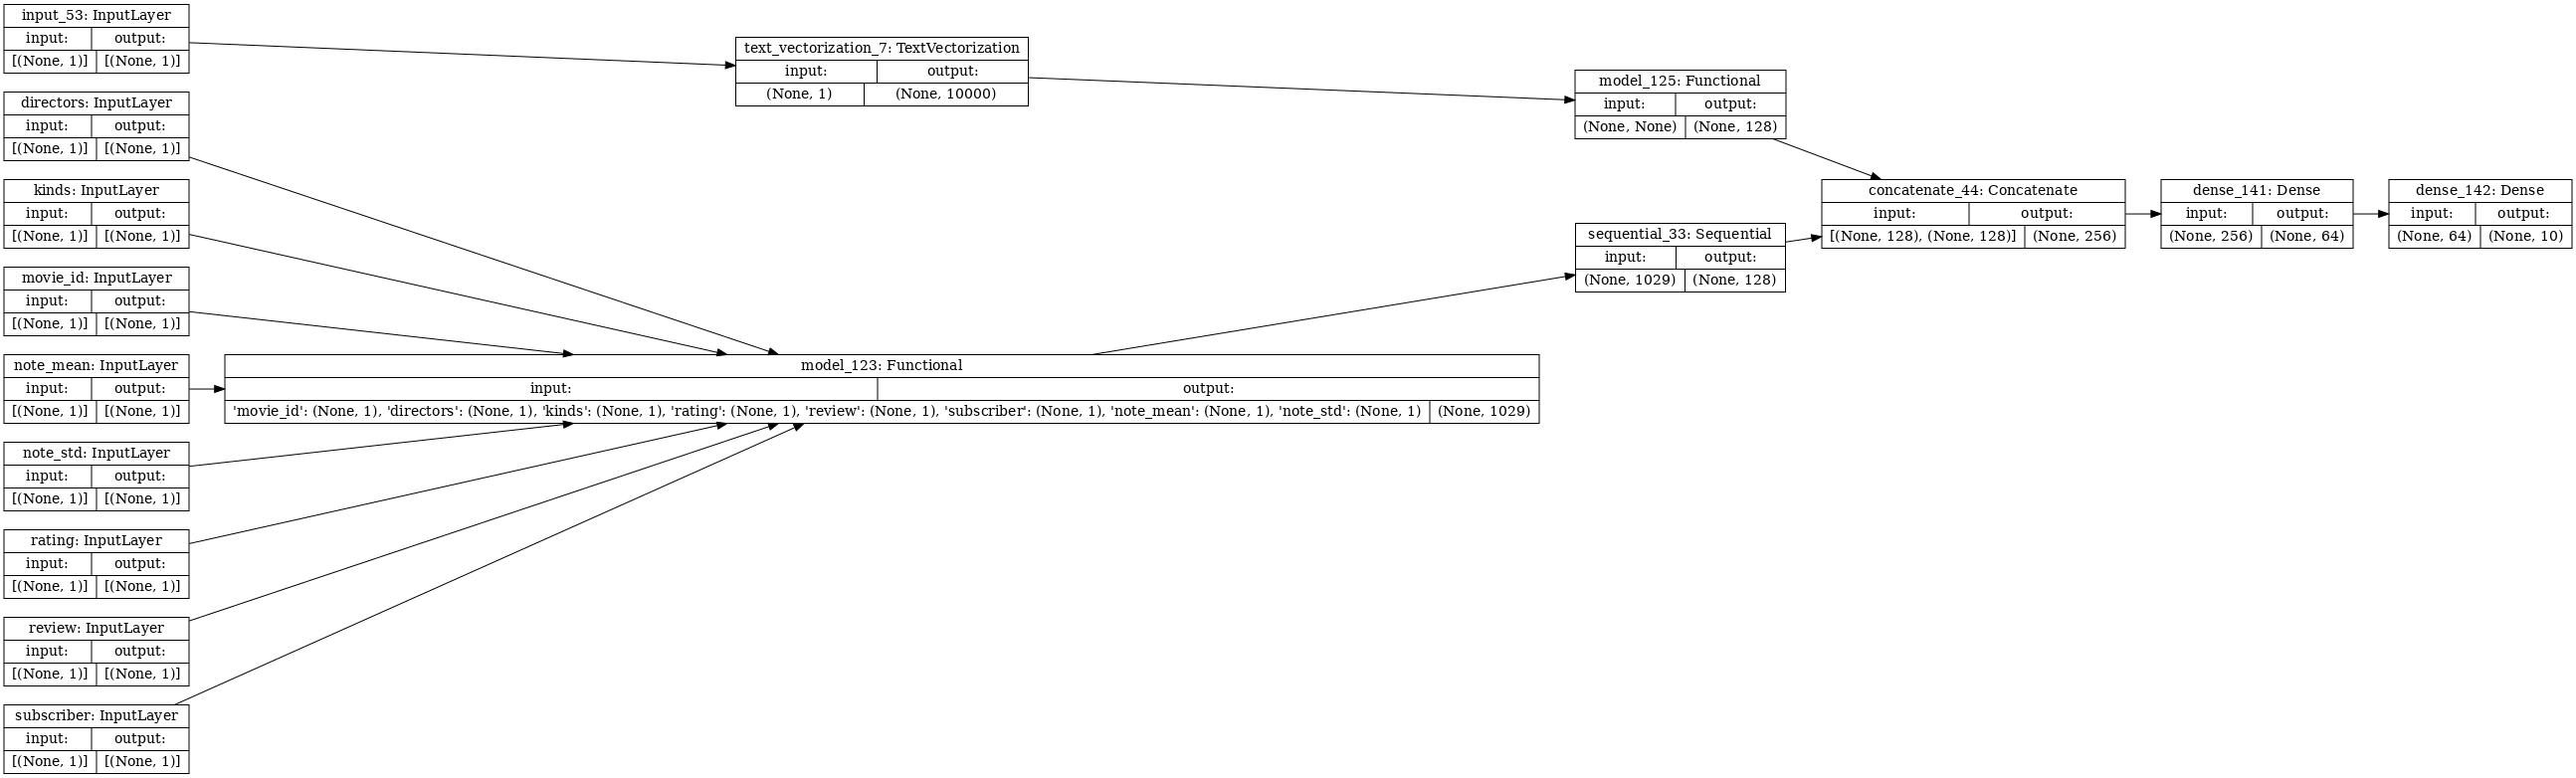

In [239]:
tf.keras.utils.plot_model(model = model , rankdir="LR", dpi=72, show_shapes=True)

In [213]:
dev_labels = tf.keras.utils.to_categorical(dev_labels, 10)

In [240]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [196]:
dev_feats.values

array([['244430', "['Bourlem Guerdjou']", "['Drame']", ..., 81.0,
        3.2830396475770924, 1.4548107990330343],
       ['244430', "['Bourlem Guerdjou']", "['Drame']", ..., 56.0,
        3.0633093525179858, 0.8432673594731496],
       ['244430', "['Bourlem Guerdjou']", "['Drame']", ..., 88.0,
        3.2044444444444444, 0.8552986627308241],
       ...,
       ['221892', "['Xavier Beauvois']", "['Comédie dramatique']", ...,
        0.0, 4.25, 0.25],
       ['221892', "['Xavier Beauvois']", "['Comédie dramatique']", ...,
        0.0, 0.5, 0.0],
       ['221892', "['Xavier Beauvois']", "['Comédie dramatique']", ...,
        0.0, 0.5, 0.0]], dtype=object)

In [241]:
# model.fit(
# 	x=dev_reviews, y=dev_labels,
# 	#validation_data=([testAttrX, testImagesX], testY),
# 	epochs=2, batch_size=64)

In [171]:
dev_feats_dict = {name:values for name, values in dev_feats_dict.items()}

In [242]:
model.fit(
	x=[dev_feats_dict, dev_reviews], y=dev_labels,
	#validation_data=([testAttrX, testImagesX], testY),
	epochs=2, batch_size=64)

Epoch 1/2
  26/1569 [..............................] - ETA: 32:21 - loss: 9.5771 - accuracy: 0.0320

KeyboardInterrupt: 